In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm, linear_model, metrics
import numpy as np
import string
import random
import string
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.stem.porter import *
import pandas as pd
import matplotlib.pyplot as plt


In [61]:
similarity = float('-inf')
similarity

-inf

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        try:
            yield eval(l)
        except:
            continue

In [4]:
def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

In [5]:
dataset = []
for d in readGz("renttherunway_final_data.json.gz"):
    dataset.append(d)


In [6]:
len(dataset)

192462

In [7]:
def heightConversion(h):
    ft, inch = h.split('\' ')
    ft = int(ft)
    inch = int(inch.replace('\"', ''))
    return ft * 12 + inch

In [8]:
new_dataset = []
punctuation = set(string.punctuation)

for d in dataset:
    feature_needed = ['weight', 'height', 'fit', 'size', 'body type', 'review_text', 'review_summary', 'rating']
    keys = list(d.keys())
    if all([i in keys for i in feature_needed]):
        d['weight'] = int(d['weight'].replace("lbs", ""))
        d['height'] = heightConversion(d['height'])
        new_dataset.append(d)

In [9]:
len(new_dataset)

153441

In [10]:
y1 = [d['fit'] for d in new_dataset]

In [11]:
dataTrain1, data_vt1, ytrain1, y_vt1 = train_test_split(new_dataset, y1, test_size=0.3, random_state=42)
dataValid1, dataTest1, yvalid1, ytest1 = train_test_split(data_vt1, y_vt1, test_size=0.5, random_state=42)
len(dataTrain1), len(dataValid1), len(dataTest1)

(107408, 23016, 23017)

In [12]:
Xtrain1 = [[1, d['weight'], d['height'], d['size']] for d in dataTrain1]
Xvalid1 = [[1, d['weight'], d['height'], d['size']] for d in dataValid1]
Xtest1 = [[1, d['weight'], d['height'], d['size']] for d in dataTest1]

In [15]:
# Baseline Model - using only weight, height and size
cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
mods = {}
F1Valid = {}
F1Train = {}
F1scores = []
for i in range(2,25):
    # baselineMod = linear_model.LogisticRegression(C=i)
    # baselineMod = KNeighborsClassifier(n_neighbors=i)
    baselineMod = DecisionTreeClassifier(max_depth=i)
    baselineMod.fit(Xtrain1,ytrain1)
    mods[i] = baselineMod
    blPred = baselineMod.predict(Xvalid1)
    blF1 = metrics.f1_score(yvalid1, blPred, average='weighted',zero_division=0)
    F1Valid[i] = blF1
    blPredTr = baselineMod.predict(Xtrain1)
    blF1Tr = metrics.f1_score(ytrain1, blPredTr, average='weighted',zero_division=0)
    F1Train[i] = blF1Tr
    F1scores.append(blF1)
    print("C = {}, F_1 score is {}.".format(str(i), str(blF1)))

C = 2, F_1 score is 0.6211854113684363.
C = 3, F_1 score is 0.6211854113684363.
C = 4, F_1 score is 0.6211854113684363.
C = 5, F_1 score is 0.6211854113684363.
C = 6, F_1 score is 0.6211797652217251.
C = 7, F_1 score is 0.6212300680822704.
C = 8, F_1 score is 0.6235943992050079.
C = 9, F_1 score is 0.622698920968555.
C = 10, F_1 score is 0.6237080607084854.
C = 11, F_1 score is 0.6244354400559678.
C = 12, F_1 score is 0.6248005453129888.
C = 13, F_1 score is 0.6254310903570377.
C = 14, F_1 score is 0.6252264958480399.
C = 15, F_1 score is 0.6262239054299196.
C = 16, F_1 score is 0.6271797472016734.
C = 17, F_1 score is 0.6276066343396025.
C = 18, F_1 score is 0.6280326427582167.
C = 19, F_1 score is 0.6276302228538293.
C = 20, F_1 score is 0.6276877698261022.
C = 21, F_1 score is 0.6275948081260582.
C = 22, F_1 score is 0.6279074227005647.
C = 23, F_1 score is 0.6280259968649508.
C = 24, F_1 score is 0.6276153863133047.


In [17]:
bestMod = mods[18]
predTest = bestMod.predict(Xtest1)
accTest1 = metrics.f1_score(ytest1, predTest, average='weighted',zero_division=0)
accTest1

0.6371152939816285

AttributeError: 'bool' object has no attribute 'any'

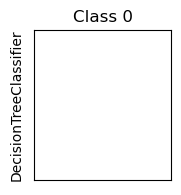

In [27]:
plt.figure(figsize=(3 * 2, 1 * 2))
plt.subplots_adjust(bottom=0.2, top=0.95)
for k in range(3):
    plt.subplot(1, 3, 1+k)
    plt.title("Class %d" % k)
    if k == 0:
        plt.ylabel("DecisionTreeClassifier")
    plt.xticks(())
    plt.yticks(())
    idx = predTest == k
    if idx.any():
        plt.scatter(Xtrain1[idx, 0], Xtrain1[idx, 1], marker="o", c="w", edgecolor="k")
ax = plt.axes([0.15, 0.04, 0.7, 0.05])

plt.show()

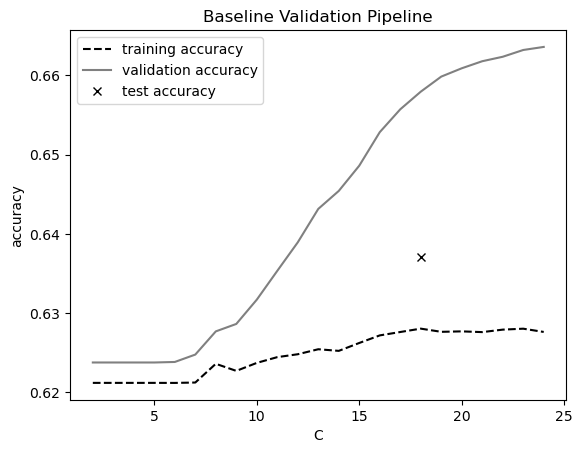

In [30]:
plt.xticks([])
plt.xlabel(r"C")
plt.ylabel(r"accuracy")
plt.title(r"Baseline Validation Pipeline")
plt.xscale('linear')
# plt.xscale('log')
plt.plot(range(2,25), list(F1Valid.values()), color='k', linestyle='--', label='training accuracy')
plt.plot(range(2,25), list(F1Train.values()), color='grey',zorder=4,label="validation accuracy")
plt.plot([18], [accTest1], linestyle='', marker='x', color='k', label="test accuracy")
plt.legend(loc='best')
plt.show()

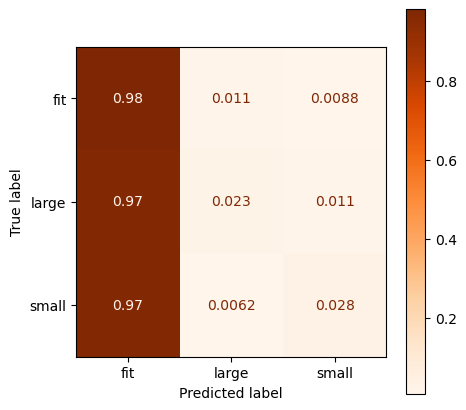

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))
metrics.plot_confusion_matrix(bestMod, Xtest1, ytest1, ax=ax, normalize='true',cmap='Oranges')
plt.show()

In [30]:
y = [d['fit'] for d in dataset]

In [159]:
dataTrain, data_vt, ytrain, y_vt = train_test_split(dataset, y, test_size=0.3, random_state=42)
dataValid, dataTest, yvalid, ytest = train_test_split(data_vt, y_vt, test_size=0.5, random_state=42)
len(dataTrain), len(dataValid), len(dataTest)

(134723, 28869, 28870)

In [32]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
sw = stopwords.words("English")
for d in dataTrain:
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        wordCount[w] += 1

len(wordCount)

32111

In [33]:
counts = [(wordCount[w],w) for w in wordCount if w not in sw]
counts.sort()
counts.reverse()
len(counts)

31996

In [34]:
words = [x[1] for x in counts[:5000]]

In [35]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [36]:
max_rating = float('-inf')
min_rating = float('inf')
for d in dataset:
    max_rating = max(int(d['rating']), max_rating)
    min_rating = min(int(d['rating']), min_rating)
max_rating, min_rating

(10, 2)

In [37]:
def feature(d): 
    feat = [0]*len(words)
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        if w in words:
            feat[wordId[w]] += 1
    feat2 = [0]*(max_rating-min_rating+1)
    feat2[max_rating-int(d['rating'])] = 1
    return [1] + feat + feat2[1:]

In [178]:
def feature2(d): 
    feat = [d['weight'], d['height'], d['size']]
    feat2 = [0]*len(words)
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        if w in words:
            feat2[wordId[w]] += 1
    feat3 = [0]*(max_rating-min_rating+1)
    feat3[max_rating-int(d['rating'])] = 1
    return [1] + feat + feat2 + feat3[1:]

In [179]:
Xtrain = [feature(d) for d in dataTrain]

KeyboardInterrupt: 

In [ ]:
Xvalid = [feature(d) for d in dataValid]

In [ ]:
Xtest= [feature(d) for d in dataTest]

In [180]:
Xtrain2 = [feature2(d) for d in dataTrain1]

In [181]:
Xvalid2 = [feature2(d) for d in dataValid1]

In [182]:
Xtest2 = [feature2(d) for d in dataTest1]

In [185]:
# Track the model which works best on the validation set
bestModel = None
bestVal = None
bestC = None
models = dict()
f1Valid = dict()
f1Train = dict()
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

for c in Cs:
    model = KNeighborsClassifier()
    model.fit(Xtrain2, ytrain1)
    models[c] = model
    predictValid = model.predict(Xvalid2)
    f1V = metrics.f1_score(predictValid, yvalid1, average='weighted', zero_division=0)
    f1Valid[c] = f1V
    predictTrain = model.predict(Xtrain2)
    f1T = metrics.f1_score(predictTrain, ytrain1, average='weighted', zero_division=0)
    f1Train[c] = f1T
    print("C = " + str(c) + ", validation F_1 score = " + str(f1V))
    if bestVal == None or f1V > bestVal:
        bestVal = f1V
        bestModel = model
        bestC = c

KeyboardInterrupt: 

In [43]:
# Track the model which works best on the validation set
bestModel = None
bestVal = None
bestC = None
models = dict()
accValid = dict()
accTrain = dict()
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

for c in Cs:
    model = linear_model.LogisticRegression(C=c)
    model.fit(Xtrain, ytrain)
    models[c] = model
    predictValid = model.predict(Xvalid)
    accV = accuracy(predictValid, yvalid)
    accValid[c] = accV
    predictTrain = model.predict(Xtrain)
    accT = accuracy(predictTrain, ytrain)
    accTrain[c] = accT
    print("C = " + str(c) + ", validation accuracy = " + str(accV))
    if bestVal == None or accV > bestVal:
        bestVal = accV
        bestModel = model
        bestC = c

C = 0.001, validation accuracy = 0.7895666632027434
C = 0.01, validation accuracy = 0.8049118431535557
C = 0.1, validation accuracy = 0.8048772039211611
C = 1, validation accuracy = 0.8023831791887491
C = 10, validation accuracy = 0.8013093629845163
C = 100, validation accuracy = 0.8007204960338079
C = 1000, validation accuracy = 0.8023485399563546


In [60]:
predictTest = bestModel.predict(Xtest)
accTest = accuracy(predictTest, ytest)
accTest

0.7956702459300312

In [49]:
accTrain

{0.001: 0.790540590693497,
 0.01: 0.807998634234689,
 0.1: 0.8138476726319931,
 1: 0.814820038152357,
 10: 0.8154954981703199,
 100: 0.8149981814537978,
 1000: 0.8145973590255562}

In [145]:
F1Score(predictValid, yvalid)

[0.6539991162174105, 0.8262880058927037, 0.6874135546334716]
[0.37938990002563444, 0.9466922968728023, 0.4097279472382523]


0.6426209629916277

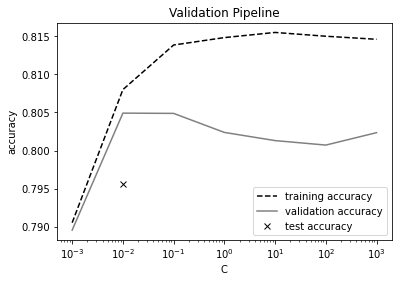

In [64]:
plt.xticks([])
plt.xlabel(r"C")
plt.ylabel(r"accuracy")
plt.title(r"Validation Pipeline")
plt.xscale('log')
plt.plot(Cs, list(accTrain.values()), color='k', linestyle='--', label='training accuracy')
plt.plot(Cs, list(accValid.values()), color='grey',zorder=4,label="validation accuracy")
plt.plot([bestC], [accTest], linestyle='', marker='x', color='k', label="test accuracy")
plt.legend(loc='best')
plt.show()